# Brief Introduction to Hyperspectral Target Detection

The goal of hyperspectral target detection is to detect whether a particular target signature is found within each pixel of a hyperspectral data cube.  In general, target detection approaches are not effective at estimating *how much* of a target is found within the field of view of a pixel (that would be unmixing) - just whether or not the material is there (with some confidence).  

The most commonly used hyperspectral target detection algorithms are the *Spectral Matched Filter* (SMF) and the *Adaptive Cosine Estimator* (ACE).  Both methods require having the target signature that you are looking for in advance.  Both approaches estimate a target confidence by  computing the cosine of the angle between the target signature and a test pixel in a whitened space (i.e., after background normalization).  The primary difference between the approaches is that SMF takes magnitude into account whereas ACE does not.  They are computed as follows:

$SMF = \frac{\left(\left(\mathbf{s}-\mu\right)^T \Sigma^{-1}\left(\mathbf{x}-\mu\right)\right)^2}{\left(\mathbf{s}-\mu\right)^T \Sigma^{-1}\left(\mathbf{s}-\mu\right)}$

$ACE = \frac{\left(\left(\mathbf{s}-\mu\right)^T \Sigma^{-1}\left(\mathbf{x}-\mu\right)\right)^2}{\left(\mathbf{s}-\mu\right)^T \Sigma^{-1}\left(\mathbf{s}-\mu\right)\left(\mathbf{x}-\mu\right)^T \Sigma^{-1}\left(\mathbf{x}-\mu\right)}$

where $\mathbf{s}$ is the target signature, $\mathbf{x}$ is the pixel under test, $\mu$ is the background mean, and $\Sigma$ is the background covariance. 

<img src="ACE.png" alt="Hyperspectral Mixing Models" style="width: 500px;"/>

**Estimating Background Mean and Covariance**  
It is often challenging to determine how to estimate the background mean and covariance.  If there are very few targets in a scene, it may be sufficient to simply use the global mean and covariance of the scene to represent the background.  There has also been work to segment the scene and, then, compute the background statistics for each segment. Please see:
<ul>
<li> H. Jenzri, H. Frigui and P. Gader, "Context dependent hyperspectral subpixel target detection," 2014 IEEE International Conference on Image Processing (ICIP), Paris, 2014, pp. 5062-5066. <url>http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7026025&isnumber=7024995</url>
<li> T. Glenn, "Context-dependent Detection in Hyperspectral Imagery," Ph.D. Thesis, University of Florida, 2013.<url> http://ufdc.ufl.edu/UFE0046170/00001/pdf?search=context-dependent </url>
<li> T. Glenn, D. Dranishnikov, P. Gader, and A. Zare, “Subpixel target detection in hyperspectral imagery using piece-wise convex spatial-spectral unmixing, possibilistic and fuzzy clustering, and co-registered LiDAR,” in IEEE Int. Geoscience and Remote Sens. Symp.(IGARSS)), 2013, pp. 1063-1066. <url>https://doi.org/10.1109/IGARSS.2013.6721347</url>
</ul>
There are also approaches in which the background statistics are computed in a "sliding-window" approach to focus only on local information during background estimation. The challenge with these approaches is determining window size.  If the window is too small, you may have issues estimating the background statistics reliably.  Yet, if the window is too large, you are no longer using only local information.  
  
**Other Detection Approaches**  
There are also many other sub-pixel target detection approaches outside of SMF and ACE in the literature.  For example, there are a number of methods that leverage spectral unmixing results to perform target detection: 
<ul>
<li> J. Broadwater and R. Chellappa, "Hybrid Detectors for Subpixel Targets," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 29, no. 11, pp. 1891-1903, Nov. 2007. <url>http://ieeexplore.ieee.org/abstract/document/4302756/</url> 
<li> A. K. Ziemann, "Local spectral unmixing for target detection," 2016 IEEE Southwest Symposium on Image Analysis and Interpretation (SSIAI), Santa Fe, NM, 2016, pp. 77-80. doi: 10.1109/SSIAI.2016.7459179 <url>http://ieeexplore.ieee.org/document/7459179/</url>
</ul>

Furthermore, there is a large body of literature and methods for *anomaly detection*.  This is distinct from target detection since there is no specific target but, rather, the goal is to detect anything that is anomalous from the background.  Much like target detection, a key aspect in anomaly detection is performing effective background estimation.  A commonly used anomaly detector is the RX detector: 
I. Reed, and X. Yu. "Adaptive multiple-band CFAR detection of an optical pattern with unknown spectral distribution." IEEE Transactions on Acoustics, Speech, and Signal Processing 38.10 (1990): 1760-1770.


In [1]:
# imports and setup
import numpy as np
import os.path
import scipy.io
from loadmat import loadmat

import matplotlib as mpl
%matplotlib inline
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*2
import matplotlib.pyplot as plt

from hsi_detectors import smf_detector,ace_detector

In [2]:
# load gulfport campus image
img_fname = 'muufl_gulfport_campus_w_lidar_1.mat'
spectra_fname = 'tgt_img_spectra.mat'

dataset = loadmat(img_fname)['hsi']

hsi = dataset['Data']
n_r,n_c,n_b = hsi.shape
wvl = dataset['info']['wavelength']
rgb = dataset['RGB']

The MUUFL Gulfport data set includes 64 emplaced targets that vary from $0.25m^2$ to $3m^2$ in size.  The spatial resolution of the hyperspectral data cube is $1m^2$.  Thus, these targets vary from super- to sub-pixel in size with the smallest targets covering a maximum of a quarter of a pixel's field of view (if located fully within that pixel and not straddling multiple pixels).  Furthermore, the targets may be subpixel due to occlusion from trees on the campus.  

Lets run target detection methods to try to find these targets: 

In [3]:
# load the target signatures
spectra_dataset = loadmat(spectra_fname)
tgts = spectra_dataset['tgt_img_spectra']['spectra']
tgt_names = spectra_dataset['tgt_img_spectra']['names']

In [4]:
# check out the shape of the targets array
tgts.shape

(72, 4)

In [5]:
# check out the target values
tgts

array([[-0.04643668, -0.08771088, -0.05649065,  0.00877197],
       [ 0.04372126,  0.06340043,  0.04305578,  0.05589003],
       [-0.01417623, -0.02577327, -0.02556048,  0.01508235],
       [ 0.01379287,  0.01020635,  0.02417886,  0.07222337],
       [ 0.0178262 ,  0.01864175,  0.02878516,  0.06782962],
       [ 0.02802114,  0.03332145,  0.03295273,  0.07798227],
       [ 0.02151081,  0.01651152,  0.03075478,  0.0839548 ],
       [ 0.03784018,  0.0375463 ,  0.04317203,  0.08893365],
       [ 0.03646573,  0.03897593,  0.0455383 ,  0.1011929 ],
       [ 0.03914298,  0.04409195,  0.0468778 ,  0.10964131],
       [ 0.03470301,  0.04401238,  0.05286763,  0.11371909],
       [ 0.04294689,  0.05214098,  0.06319278,  0.12679571],
       [ 0.03920482,  0.06021807,  0.06819298,  0.13389105],
       [ 0.03579593,  0.06145237,  0.07488994,  0.14194946],
       [ 0.04385028,  0.07731329,  0.10008584,  0.15233621],
       [ 0.03975984,  0.07437797,  0.11678438,  0.15524897],
       [ 0.04383426,  0.

In [6]:
# look at the target names
tgt_names

array(['brown', 'dark_green', 'faux_vineyard_green', 'pea_green'],
      dtype=object)

Text(0.5, 1.0, 'MUUFL Target Signatures')

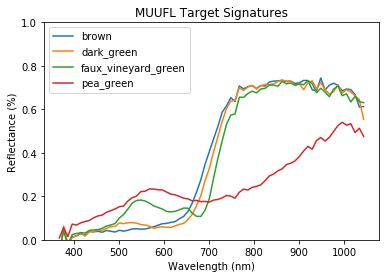

In [20]:
# plot the target signature spectra
plt.plot(wvl,tgts)
plt.legend(tgt_names)
plt.ylim(0,1)
plt.ylabel('Reflectance (%)')
plt.xlabel('Wavelength (nm)')
plt.title('MUUFL Target Signatures')

In [8]:
# select the spectra for the Brown target, try to find it using Adaptive Cosine Estimator (ACE)
br_sig = tgts[:,0]

conf = ace_detector(hsi,br_sig)

Text(0.5, 1.0, 'ACE Confidence Map')

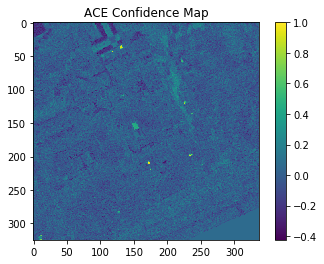

In [9]:
# plot the ACE confidence map
# ACE confidence ranges from -1 to 1 with -1 having low confidence and 1 having high confidence
plt.imshow(conf)
plt.colorbar()
plt.title('ACE Confidence Map')

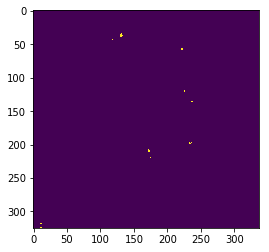

In [10]:
# Apply threshold to confidence map to make target declarations
# AKA select all pixels with a confidence higher than 0.5
plt.imshow(conf > 0.5)

Text(0.5, 1.0, 'SMF Confidence Map')

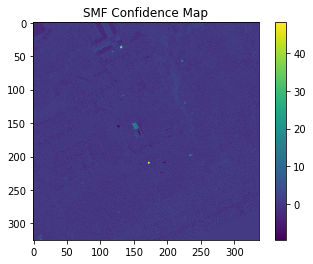

In [11]:
# run the same signature (brown target) in Spectral Matched Filter (SMF)
conf_smf = smf_detector(hsi,br_sig)
plt.imshow(conf_smf)
plt.colorbar()
plt.title('SMF Confidence Map')

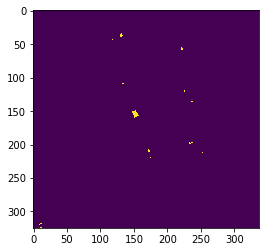

In [12]:
# Apply threshold to make declarations
# AKA select all pixels with a confidence higher than 5
plt.imshow(conf_smf > 5)

In [13]:
# load the ground truth target locations
gt = dataset['groundTruth']
gt_row,gt_col,gt_name = gt['Targets_rowIndices'],gt['Targets_colIndices'],gt['Targets_Type']

br_rc = [(row,col) for row,col,name in zip(gt_row,gt_col,gt_name) if name == 'brown']

In [14]:
# inspect
br_rc

[(137, 236),
 (121, 226),
 (105, 218),
 (181, 243),
 (200, 234),
 (215, 253),
 (223, 256),
 (187, 227),
 (191, 213),
 (231, 180),
 (222, 176),
 (211, 172),
 (238, 147),
 (264, 95),
 (293, 143)]

Text(0.5, 1.0, 'SMF Target Detection')

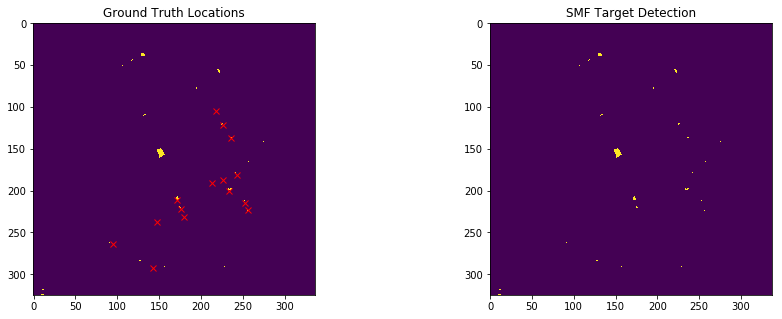

In [23]:
# plot the ground truth over the declaration map
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(conf_smf > 5)
for r,c in br_rc:
    plt.plot(c,r,'rx')
plt.title('Ground Truth Locations')
plt.subplot(1,2,2)
plt.imshow(conf_smf > 5)
plt.title('SMF Target Detection')